<a href="https://colab.research.google.com/github/qweliant/DS-Unit-2-Kaggle-Challenge/blob/master/module1/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'module1'))
	print(os.getcwd())
except:
	pass



In [0]:
from IPython import get_ipython


  Lambda School Data Science, Unit 2: Predictive Modeling

  # Kaggle Challenge, Module 1

  ## Assignment
  - [ ] Do train/validate/test split with the Tanzania Waterpumps data.
  - [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
  - [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
  - [ ] Get your validation accuracy score.
  - [ ] Get and plot your feature importances.
  - [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
  - [ ] Commit your notebook to your fork of the GitHub repo.


  ## Stretch Goals

  ### Reading

  - A Visual Introduction to Machine Learning
    - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
    - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
  - [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
  - [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
  - [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
  - [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
  - [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


  ### Doing
  - [ ] Add your own stretch goal(s) !
  - [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
  - [ ] Make exploratory visualizations and share on Slack.


  #### Exploratory visualizations

  Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data.

  For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

  ```python
  train['functional'] = (train['status_group']=='functional').astype(int)
  ```



  You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

  - Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
  - Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

  You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

  You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

  #### High-cardinality categoricals

  This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

  ```python
  # Reduce cardinality for NEIGHBORHOOD feature ...

  # Get a list of the top 10 neighborhoods
  top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

  # At locations where the neighborhood is NOT in the top 10,
  # replace the neighborhood with 'OTHER'
  train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
  test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
  ```


In [3]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    get_ipython().system('pip install category_encoders==2.*')

# If you're working locally:
else:
    DATA_PATH = '../data/'



In [4]:
import pandas as pd
import category_encoders as ce
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape



((59400, 41), (14358, 40))

In [5]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [0]:
def wrangle(X):
    X = X.copy()

    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
    X['construction_year'] = X['construction_year'].astype(dtype='int32')
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
    X = X.drop(columns=['quantity_group', 'quality_group', 'waterpoint_type_group', 'extraction_type_group', 'extraction_type_class', 'management_group', 'source_type'])

    
    X.date_recorded = pd.to_datetime(X.date_recorded)
    X =  X.set_index('date_recorded')
    
    X['inspec_year'] = X.index.year.astype(dtype='int32')
    X['time_before_inspection'] = (X.inspec_year - X.construction_year) 
    return(X)


def train_validate(df):
    train_set, validation_set = train_test_split(df, train_size=0.80, test_size=0.20, stratify=train['status_group'], random_state=42, )
    return train_set, validation_set

In [0]:
train_set, validation_set = train_validate(train)

In [0]:
train_set = wrangle(train_set)
validation_set = wrangle(validation_set)
test = wrangle(test)

In [9]:
train_set.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,management,payment,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,inspec_year,time_before_inspection
date_recorded,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-07-27,72938,0.0,NaN,NaN,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,NaN,True,GeoData Consultants Ltd,VWC,K,NaN,NaN,gravity,vwc,never pay,never pay,soft,insufficient,spring,groundwater,communal standpipe,functional,False,False,True,True,True,2011,NaN
2011-03-23,65358,500.0,Rc Church,2049.0,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175.0,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008.0,gravity,wua,pay monthly,monthly,soft,enough,spring,groundwater,communal standpipe,functional,False,False,False,False,False,2011,3.0
2011-03-07,469,25.0,Donor,290.0,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300.0,True,GeoData Consultants Ltd,VWC,NaN,False,2010.0,india mark ii,vwc,pay per bucket,per bucket,salty,insufficient,shallow well,groundwater,hand pump,functional,False,False,False,False,False,2011,1.0
2011-07-31,1298,0.0,Government Of Tanzania,NaN,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,NaN,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,other,vwc,never pay,never pay,soft,enough,shallow well,groundwater,other,non functional,False,False,True,True,True,2011,NaN
2011-03-10,27001,0.0,Water,NaN,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,NaN,True,GeoData Consultants Ltd,VWC,Zeje,True,NaN,mono,vwc,pay per bucket,per bucket,soft,enough,machine dbh,groundwater,communal standpipe,functional,False,False,True,True,True,2011,NaN


In [0]:
# train_set['inspec_year'] = train_set.index.year.astype(dtype='int32')
# train_set.inspec_year.head()

In [0]:
# train.groupby('quantity')['status_group'].value_counts(normalize=True)
# # train_set['construction_year'] = train_set['construction_year'].astype(dtype='int32') 

In [0]:
target = "status_group"
numbers_columns = train_set.select_dtypes(include='number').columns.drop('id').tolist()
categorical_columns = train_set.select_dtypes(exclude='number').columns.drop(target).tolist()
drop_high_cardinality = [col for col in categorical_columns if train_set[col].nunique() <= 50]
features = numbers_columns + drop_high_cardinality

In [0]:
test.replace({'functional':0, 'functional needs repair':1, 'non functional':2}, inplace=True)

In [0]:
X_train = train_set[features]
y_train = train_set[target]
X_val = validation_set[features]
y_val = validation_set[target]
X_test = test[features]

In [15]:
pipeline1 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=21,random_state=42)
)

pipeline1.fit(X_train, y_train)


print('Train Accuracy:', pipeline1.score(X_train, y_train))
print('Validation Accuracy:', pipeline1.score(X_val, y_val))

y_pred = pipeline1.predict(X_test)

Train Accuracy: 0.8064814814814815
Validation Accuracy: 0.7721380471380471


In [16]:
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=42,random_state=42)
)

pipeline2.fit(X_train, y_train)


print('Train Accuracy:', pipeline2.score(X_train, y_train))
print('Validation Accuracy:', pipeline2.score(X_val, y_val))

y_pred = pipeline2.predict(X_test)

Train Accuracy: 0.7837962962962963
Validation Accuracy: 0.7619528619528619


In [17]:
pipeline3 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline3.fit(X_train, y_train)


print('Train Accuracy:', pipeline3.score(X_train, y_train))
print('Validation Accuracy:', pipeline3.score(X_val, y_val))

y_pred = pipeline3.predict(X_test)

Train Accuracy: 0.9959175084175084
Validation Accuracy: 0.8041245791245791


In [18]:
pipeline4 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline4.fit(X_train, y_train)


print('Train Accuracy:', pipeline4.score(X_train, y_train))
print('Validation Accuracy:', pipeline4.score(X_val, y_val))

y_pred = pipeline4.predict(X_test)

Train Accuracy: 0.9959385521885522
Validation Accuracy: 0.8041245791245791


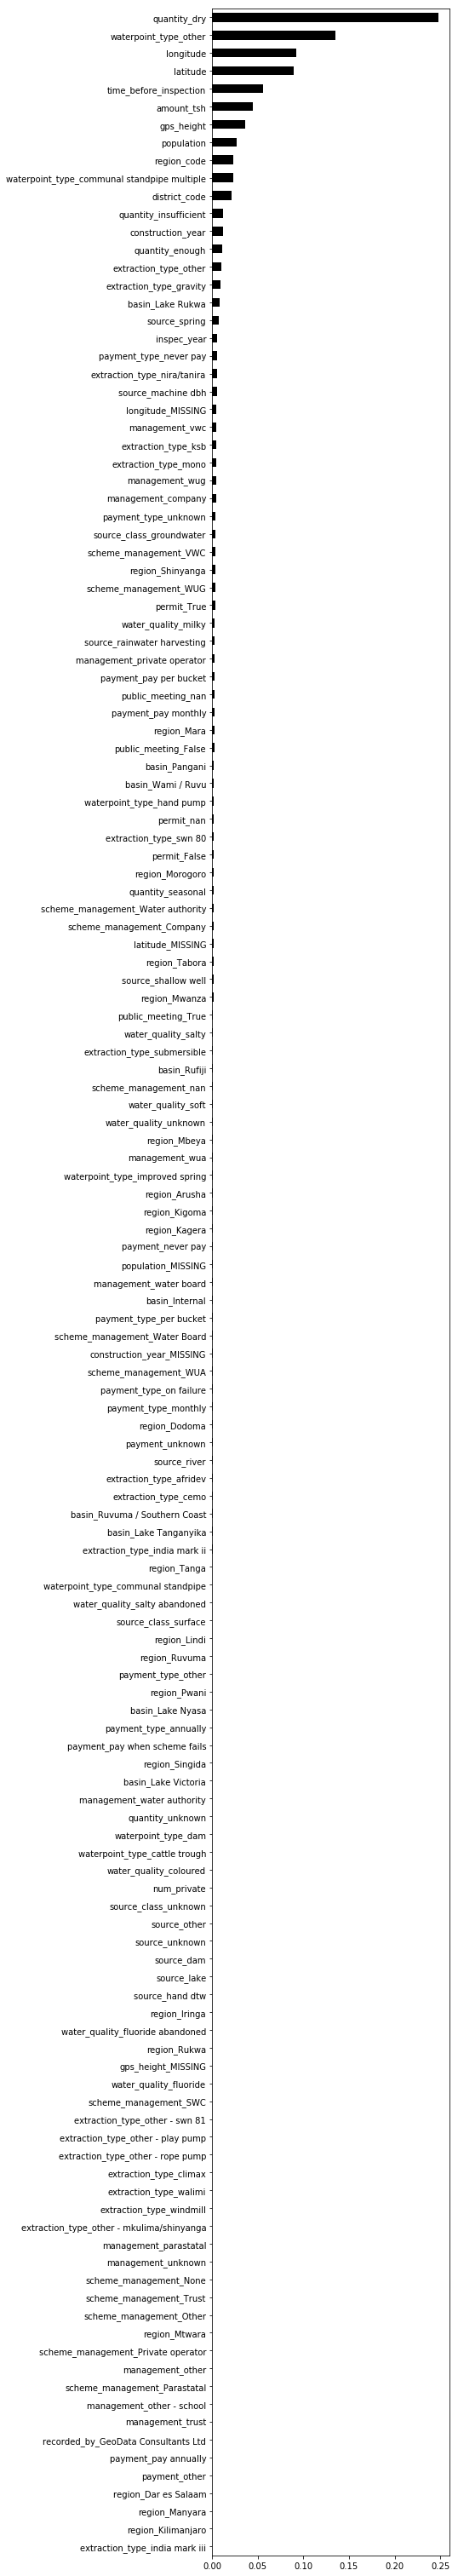

In [19]:
model = pipeline1.named_steps['decisiontreeclassifier']
encoder = pipeline1.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(5,55))
importances.sort_values().plot.barh(color='black');

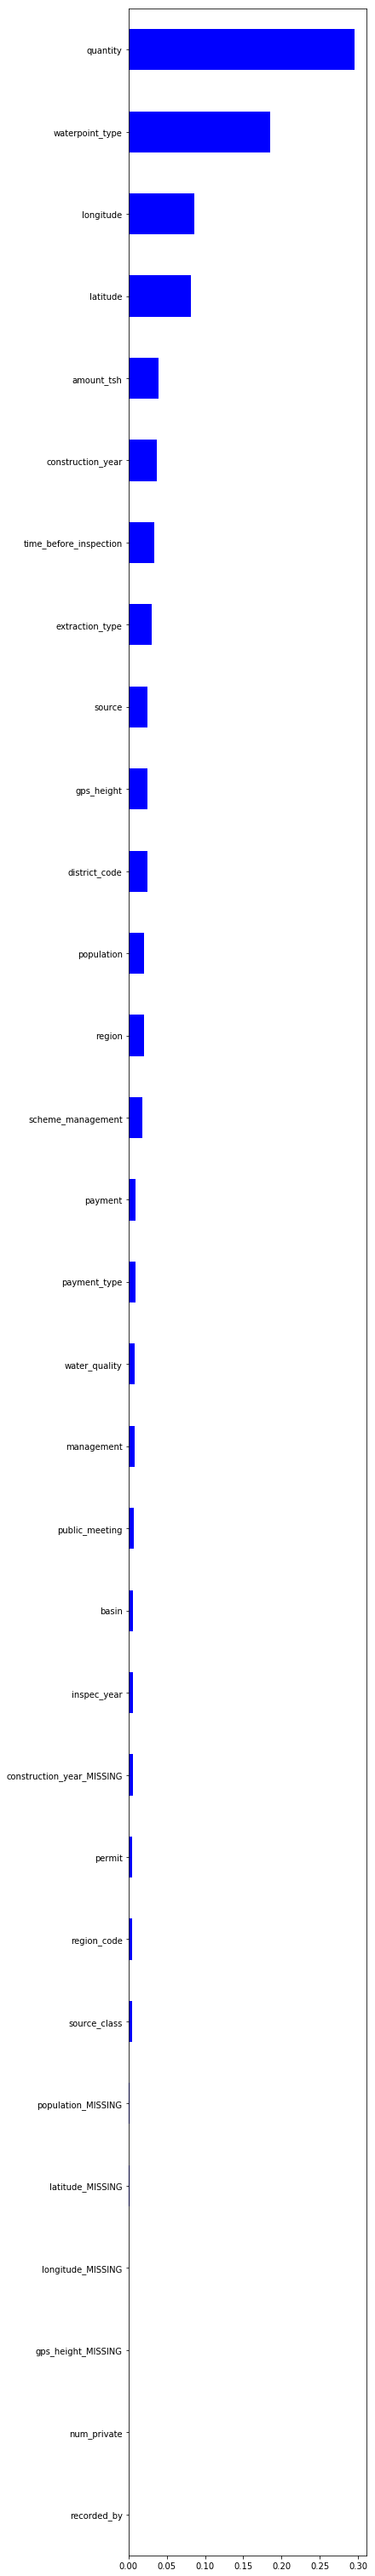

In [21]:
model = pipeline2.named_steps['decisiontreeclassifier']
encoder = pipeline2.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(5,55))
importances.sort_values().plot.barh(color='blue');

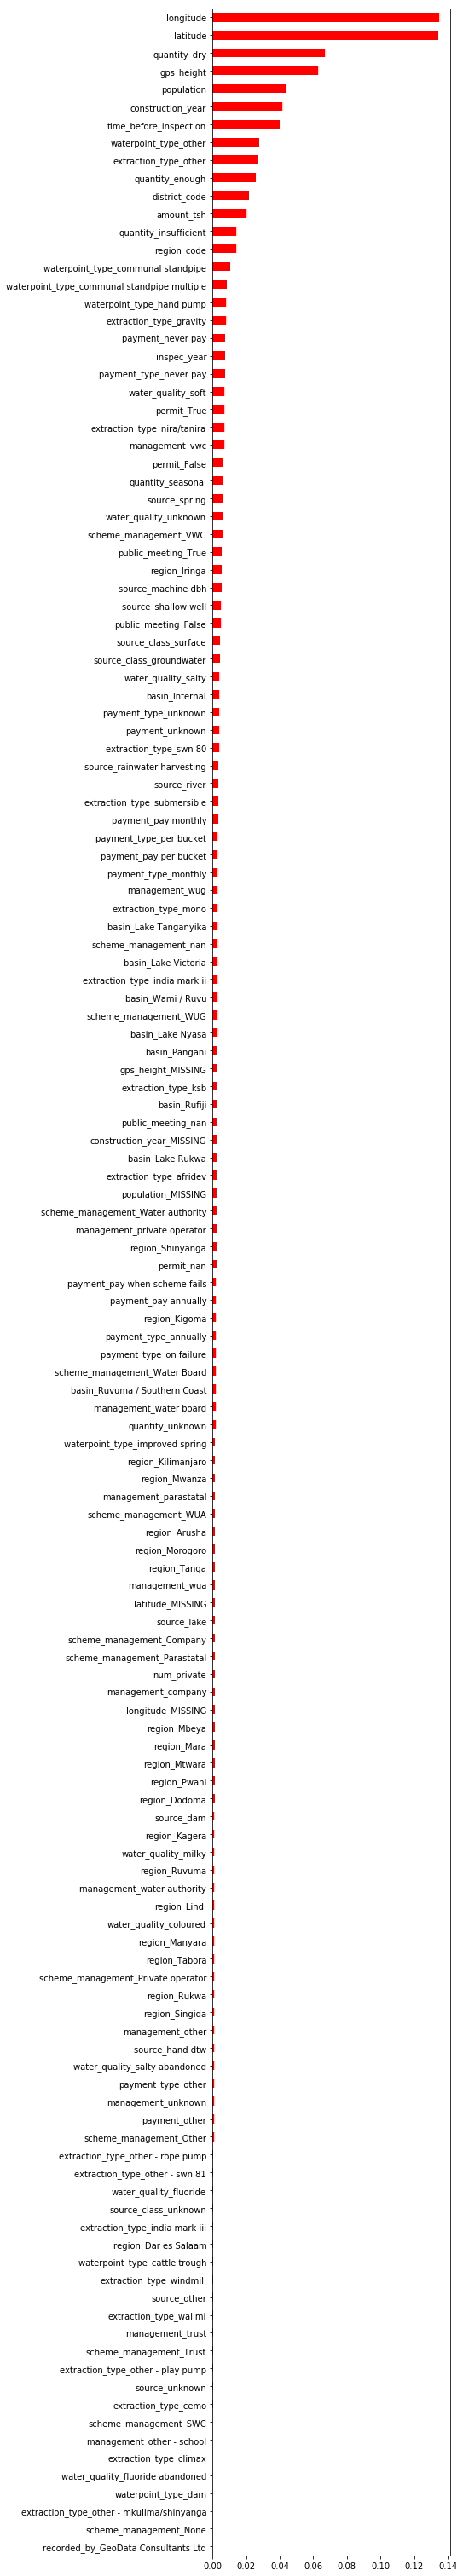

In [25]:
model = pipeline3.named_steps['randomforestclassifier']
encoder = pipeline3.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(5,55))
importances.sort_values().plot.barh(color='red');

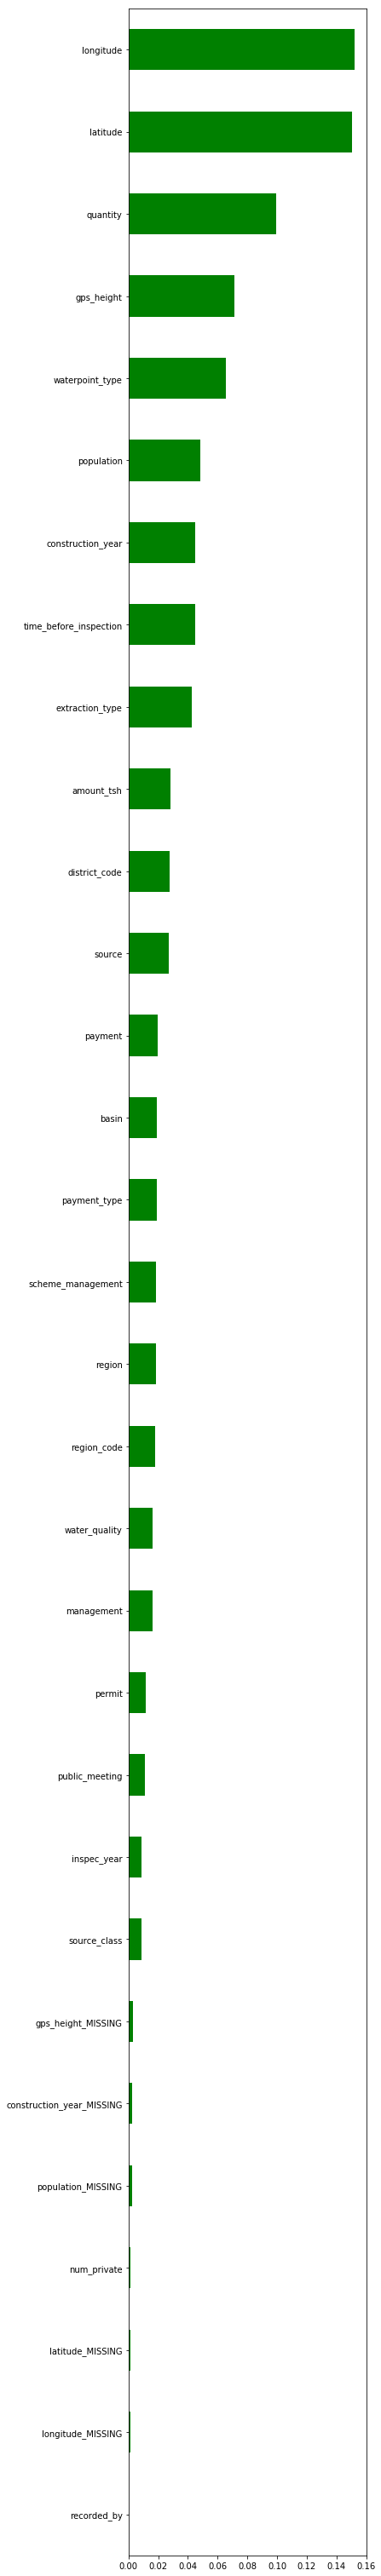

In [24]:
model = pipeline4.named_steps['randomforestclassifier']
encoder = pipeline4.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(5,55))
importances.sort_values().plot.barh(color='green');

In [26]:
# train_set.date_recorded = pd.to_datetime(train_set.date_recorded)
# validation_set.date_recorded = pd.to_datetime(validation_set.date_recorded)
test = test.copy()
y_pred = pipeline3.predict(X_test)
submission = test[['id']]
submission['status_group'] = y_pred
submission.replace({0:'functional', 1:'functional needs repair', 2:'non functional'}, inplace=True)
submission.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


,id,status_group
date_recorded,,
2013-02-04,50785,functional
2013-02-04,51630,functional
2013-02-01,17168,functional
2013-01-22,45559,non functional
2013-03-27,49871,functional


In [0]:
from google.colab import files
submission.to_csv('submission.csv', index=False)
files.download('submission.csv')